**Interrupts**

In langgrah, we can use **interrupts** to stop graph execution at specific points.

We use this to collect input from a user and continue execution with collected input.


In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

#load environment variables
load_dotenv()


api_key=os.getenv("GITHUB_TOKEN")

llm=ChatOpenAI(
    model="gpt-4o",
    openai_api_key=api_key,
    base_url="https://models.inference.ai.azure.com"
)



In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver 


class State(TypedDict):
    input: str
    user_feedback: str

def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback---")
    feedback=interrupt("Please provide feedback: ")
    return {"user_feedback": feedback}

def step_3(state):
    print("---Step 3---")
    pass

builder=StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

#set up memory
memory=InMemorySaver()

#Add
graph=builder.compile(checkpointer=memory)




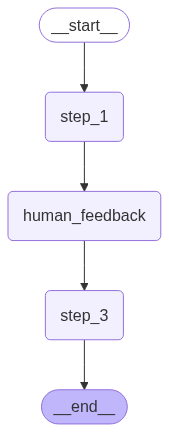

In [5]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
#input
initial_input={"input":"hello world"}

#thread
thread={"configurable":{"thread_id":"1"}}

#run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")


---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback: ', resumable=True, ns=['human_feedback:735e7fea-b0b8-6413-0c5e-edb98502c4e3']),)}




We get an interruption in our application.

Now let us use the **Command** object to resume the graph from the interrupted state, passing **resume**

In [8]:
#continue the graph execution
for even in graph.stream(
    Command(resume="got to step 3!"),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback: ', resumable=True, ns=['human_feedback:735e7fea-b0b8-6413-0c5e-edb98502c4e3']),)}


---Step 3---
{'__interrupt__': (Interrupt(value='Please provide feedback: ', resumable=True, ns=['human_feedback:735e7fea-b0b8-6413-0c5e-edb98502c4e3']),)}


